# Plotting a BOSS Stellar Spectrum and Best Fit

## Learning Goals
By the end of this tutorial, you will:
- Know how to manually retrieve SDSS spectrum files
- Understand some of the structure of a fits file containing a BOSS spectrum
- (Optionally) have a copy of the AllStarSnowWhite file

## Introduction
SDSS V now uses the BOSS optical spectrograph to observe stars. White dwarfs are a particularly large SDSS V program, and the data are reduced by a product called Snow White.

In this short tutorial we will briefly cover how to retrieve an object's sdss_id from the allStarSnowWhite file, then show how to build the file name and retrieve the BOSS spectrum of that star from the SDSS Science Archive Server (SAS).

## Imports
This tutorial requires three commonly used python packages, and an SDSS specific package
- _numpy_ for doing large array operations
- _matplotlib_ for plotting
- _astropy_ for reading fits table

Missing packages can be installed via `pip install numpy matplotlib astropy`

## Optional Import

A portion of this tutorial will demonstrate how to use `sdss_access` to download sdss data in the background, saving some manual effort. This is optional, as we first show how to find these files manually.

`sdss_access` can be installed via `pip install sdss-access`

The last two lines of the next block should be commented out if you choose not install `sdss_access`

# Note!
If you already have `sdss_access` installed but have trouble with these file types, try upgrading to the latest version `pip install --upgrade sdss-access`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

from sdss_access import Access
access = Access(release='dr19')

Let's get the summary file for SnowWhite. The file is approximately 1.6 MB and can be downloaded from 
https://data.sdss5.org/sas/dr19/spectro/astra/0.6.0/summary/astraAllStarSnowWhite-0.6.0.fits.gz

The variable `wd_file` is set to just the name of the file. You may need to modify it to point to the full path if the file is not in the same location as this notebook.

HDU 1 contains the parameters from BOSS spectra, which is what SnowWhite runs on.

If you are running this notebook on SciServer, this file is already available. Uncomment the file path to rename the `wd_file` variable to point to this version.

In [ ]:
wd_file = "astraAllStarSnowWhite-0.6.0.fits.gz"

# wd_file = "/home/idies/workspace/sdss_sas/dr19/spectro/astra/0.6.0/summary/astraAllStarSnowWhite-0.6.0.fits.gz"

allStarSnowWhiteFull = Table.read(wd_file, hdu=1)
print(len(allStarSnowWhiteFull))

10364


First we'll apply a cut to remove lower Signal-to-Noise (SNR) stars and stars with higher reduced χ^2 values, leaving only the stars with highest quality data and good fits

In [3]:
allStarSnowWhite = allStarSnowWhiteFull[np.logical_and(allStarSnowWhiteFull["nmf_rchi2"] < 2, allStarSnowWhiteFull["snr"] > 50)]
print(len(allStarSnowWhite))

52


## Choosing a star and constructing the data path

Let's compare the observed spectrum and best-fit SnowWhite model for a single star.

First, grab the SDSS ID for a star, let's say the first. This is the info we need to grab the stacked spectrum and best-fit model.

In [4]:
single_star = allStarSnowWhite[0]
sdss_id = str(single_star["sdss_id"])

## SciServer

If you are running this notebook on SciServer, the data are already available. We'll set the `mwmStar_filename` and `astraStar_filename` variables, then skip ahead to loading the files.

In [5]:
file_root = "/home/idies/workspace/sdss_sas_ipl/dr19/spectro/astra/0.6.0/spectra/star/"
mwmStar_filename = file_root + f"{sdss_id[-4:-2]}/{sdss_id[-2:]}/mwmStar-0.6.0-{sdss_id}.fits"
astraStar_filename = file_root +  f"{sdss_id[-4:-2]}/{sdss_id[-2:]}/astraStarSnowWhite-0.6.0-{sdss_id}.fits"

If running on SciServer, **skip ahead to the "Loading Data" section**. Running the cells between here and there will reset the file names.

## Manually downloaded data

If you are running this notebook yourself, SDSS Spectra can be manually downloaded from the Science Archive Server (SAS) if you carefully construct the paths. Many may find it easier to use the `sdss_access` product, if so you may skip to that section.

To manually access data, the URL of the mwmStar file (containing the stacked observed spectrum) can be constructed from the SDSS ID, and the URL of the astraStarSnowWhite file (containing the best-fit model spectrum).

In [6]:
mwmStar_filename = f"mwmStar-0.6.0-{sdss_id}.fits"
f"https://dr19.sdss5.org/sas/dr19/spectro/astra/0.6.0/spectra/star/{sdss_id[-4:-2]}/{sdss_id[-2:]}/" + mwmStar_filename

'https://data.sdss5.org/sas/dr19/spectro/astra/0.6.0/spectra/star/07/10/mwmStar-0.6.0-66090710.fits'

Navigating to that URL (copy and paste in any browser, or possibly just click the link) should begin the download immediately. Move the file to the same directory as this notebook, or modify the mwmStar_filename with the path to the file.

Now we need to grab the astraStar file in order to load the model flux. SnowWhite astraStar filenames contains WD instead of SnowWhite for legacy reasons.

In [7]:
astraStar_filename = f"astraStarSnowWhite-0.6.0-{sdss_id}.fits"
f"https://dr19.sdss5.org/sas/dr19/spectro/astra/0.6.0/results/star/{sdss_id[-4:-2]}/{sdss_id[-2:]}/" + astraStar_filename

'https://data.sdss5.org/sas/dr19/spectro/astra/0.6.0/results/star/07/10/astraStarSnowWhite-0.6.0-66090710.fits'

Download and move the astraStar file just as before.

Alternatively, the files can be downloaded in the background using `sdss_access`.

## sdss-access

sdss-access has extensive [documentation](https://sdss-access.readthedocs.io/en/latest/), but we should mention a few things. First if you are a member of the collaboration accessing proprietary data, you need to set up a [.netrc file](https://sdss-access.readthedocs.io/en/latest/auth.html). After that usage is the same for everyone.

You need specify the file species you need, in this case 'mwmStar', then a series of key word arguments that vary depending on the file species. A list of file species and their keyword arugments is [available](https://sdss-access.readthedocs.io/en/latest/paths.html).

The four lines of code below show an example of retreiving an sdss spectrum. `access.commit()` will retrieve the file and save it to your local SAS, `$SAS_BASE_DIR`, with the same structure as the SAS (so it will be many files deep)

In [8]:
access.remote()
access.add('mwmStar', v_astra='0.6.0', component='', sdss_id=sdss_id)
access.add('astraStarSnowWhite', v_astra='0.6.0', component='', sdss_id=sdss_id)
access.set_stream()
access.commit()

Progress:   0%|                | 0/2 [00:00<?, ?files/s, n_files=2, n_streams=2]

SDSS_ACCESS> Done!


Now we'll change the file names we created before to point to the new paths created by `sdss_access`

In [9]:
mwmStar_filename = access.full('mwmStar', v_astra='0.6.0', component='', sdss_id=sdss_id)
print(mwmStar_filename)
access.exists('', full=mwmStar_filename)

astraStar_filename = access.full('astraStarSnowWhite', v_astra='0.6.0', component='', sdss_id=sdss_id)
print(astraStar_filename)
access.exists('', full=astraStar_filename)

/Users/jdonor/sas/dr19/spectro/astra/0.6.0/spectra/star/07/10/mwmStar-0.6.0-66090710.fits
/Users/jdonor/sas/dr19/spectro/astra/0.6.0/results/star/07/10/astraStarSnowWhite-0.6.0-66090710.fits


True

## Loading data

Now, load the data and model spectrum and make plots.

Again, HDU 1 contains the data from BOSS.

We want the first entry in each of these columns. They are stored this way to be as similar as possible to mwmVisit files, which contain separate spectra for each visit.

In [10]:
mwmStar = Table.read(mwmStar_filename, hdu=1)

print(mwmStar)

obs_wl = mwmStar["wavelength"][0]
obs_flux = mwmStar["flux"][0]

spectrum_pk_id release filetype ... nmf_rectified_model_flux nmf_rchi2 nmf_flags
-------------- ------- -------- ... ------------------------ --------- ---------
      41553629   sdss5  mwmStar ... 0.97839606 .. 0.99388695 1.6908267         0


Now we can load the astraStar file and grab the model flux. The structure is purposefully similar to the mwmStar file

In [11]:
astraStar = Table.read(astraStar_filename, hdu=1)
model_flux = astraStar["model_flux"][0]

## Plot the data and model

The model_flux, obs_flux, and obs_wl arrays are the same length, as one might expect.

However, there is some kind of ringing going on at the blue end of the spectrum, which we'll mask out. Uncomment the other line to see it.

Text(0, 0.5, 'flux')

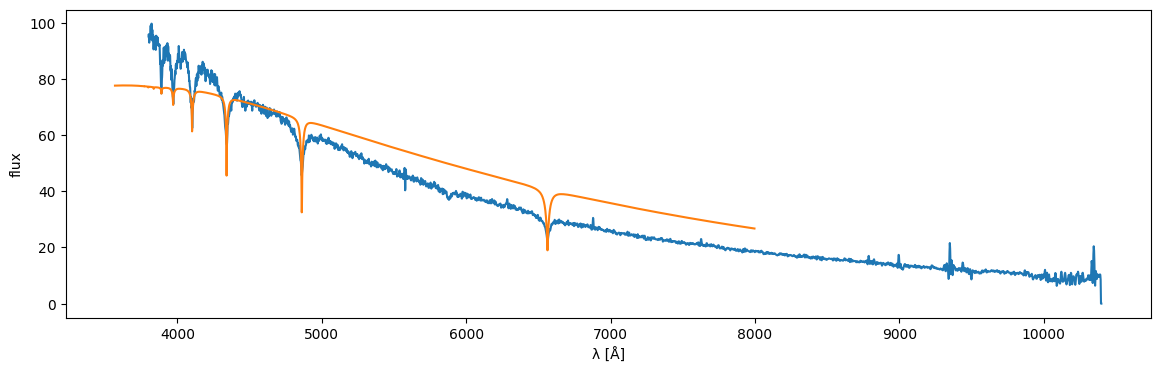

In [12]:
plt.figure(figsize=(14,4))

mask = obs_wl > 3800

plt.plot(obs_wl[mask], obs_flux[mask])
plt.plot(obs_wl, model_flux, zorder=10)
plt.xlabel("λ [Å]")
plt.ylabel("flux")

### About this notebook

This notebook was created to illustrate how to use an BOSS spectrum and model fit by Snow White

**Authors**: Adam Wheeler, John Donor

**Last Update**: 2025 April 2

If you use `astropy`  for published research, please cite the
authors. Follow this link for more information about citing `astropy`:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)

And of course please [cite](https://sdss.org/collaboration/citing-sdss/) SDSS when you use our data.